### Import Libraries and Data

In [ ]:
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
from datetime import datetime
import pytz
from tensorflow.keras.callbacks import LearningRateScheduler,TensorBoard,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam,Nadam
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import random
from tqdm import tqdm
import shutil
import io
from nltk.translate.gleu_score import sentence_gleu
import pickle

In [ ]:
final_df = pd.read_csv('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/final_df_preprocessed_2021111201.csv')

In [ ]:
final_df = final_df[final_df['incorrect_word_count'] <= 12]
final_df.shape

(266487, 6)

In [ ]:
final_df = final_df[['correct','incorrect']]

In [ ]:
final_df[final_df.isna().any(axis=1)]

,correct,incorrect
14886,NaN,NaN
20290,NaN,this `` pen pal `` means simple friends
42611,NaN,NaN
45742,D,NaN
53063,NaN,NaN
57240,.,NaN
61930,NaN,I have studying
78316,NaN,June
142903,just kidding lol,NaN
151210,D,NaN


###  Train Test Split

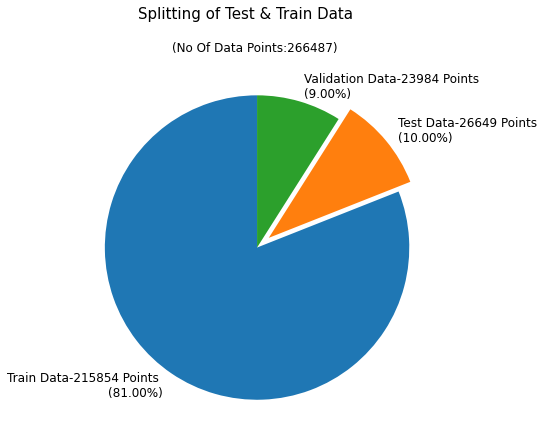

In [ ]:
train,test = train_test_split(final_df, test_size=0.1,random_state=15)
train,validation = train_test_split(train, test_size=0.1)
fig,ax = plt.subplots(figsize =(10, 7))
labels_split = ['Train', 'Test','Validation'] 
sizes_split = [len(train),len(test),len(validation)]
pcts_split = [f'{l} Data-{s} Points \n({s*100/sum(sizes_split):.2f}%)' for s,l in zip(sizes_split, labels_split)] 
ax.pie(sizes_split, labels = pcts_split, startangle = 90, 
       explode=(0,0.1,0),textprops = {"fontsize":12} )

plt.suptitle(f'Splitting of Test & Train Data ', fontsize = 15)
plt.title(f'(No Of Data Points:{sum(sizes_split)}) ', fontsize = 12)
plt.show()

In [ ]:
train['dec_correct_inp'] = '<start> ' + train['correct'].astype(str)
train['dec_correct_out'] = train['correct'].astype(str) + ' <end>'

validation['dec_correct_inp'] = '<start> ' + validation['correct'].astype(str)
validation['dec_correct_out'] = validation['correct'].astype(str) + ' <end>'

test['dec_correct_inp'] = '<start> ' + test['correct'].astype(str)
test['dec_correct_out'] = test['correct'].astype(str) + ' <end>'

In [ ]:
train.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
264629,I like going to parties .,I like going to patry .,<start> I like going to parties .,I like going to parties . <end>
431319,The style we teach in is supposed to be gettin...,The style it is supposed to be is getting cha...,<start> The style we teach in is supposed to b...,The style we teach in is supposed to be gettin...
268738,Maybe not .,may be not .,<start> Maybe not .,Maybe not . <end>
454269,It makes me so sad .,It made me so sad emotion .,<start> It makes me so sad .,It makes me so sad . <end>
10218,It is an HTC Hero .,htc hero .,<start> It is an HTC Hero .,It is an HTC Hero . <end>


In [ ]:
test.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
341422,Cultural differences often cause confrontations .,Cultural differnces often cause confrontations .,<start> Cultural differences often cause confr...,Cultural differences often cause confrontation...
374434,"Besides these reasons , he might help people w...","Besides these reasons , he might help people s...","<start> Besides these reasons , he might help ...","Besides these reasons , he might help people w..."
412867,"But this summer , I went to Mongolia .","But this summer , I went Mongolia .","<start> But this summer , I went to Mongolia .","But this summer , I went to Mongolia . <end>"
64254,So I decided to write a diary entry everyday .,So I decided to write diary everyday .,<start> So I decided to write a diary entry ev...,So I decided to write a diary entry everyday ....
312233,I am going to study Italian too .,I am going to study italian too .,<start> I am going to study Italian too .,I am going to study Italian too . <end>


In [ ]:
validation.sample(5)

,correct,incorrect,dec_correct_inp,dec_correct_out
193640,"In this entry , I used the perfect tense many ...","In this entry , I used a perfect tense many ti...","<start> In this entry , I used the perfect ten...","In this entry , I used the perfect tense many ..."
351078,I have more to learn about the English language .,I have to learn English more more .,<start> I have more to learn about the English...,I have more to learn about the English languag...
173709,I feel very sleepy now .,I feel sleepy very much now .,<start> I feel very sleepy now .,I feel very sleepy now . <end>
168521,Keeping a blog is really useful for me to moti...,Keeping blog is really useful for me to motiva...,<start> Keeping a blog is really useful for me...,Keeping a blog is really useful for me to moti...
9244,"Yes , I am thin skined .","Yes , I am thin skkined .","<start> Yes , I am thin skined .","Yes , I am thin skined . <end>"


In [ ]:
train.to_csv('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/train_20211112.csv')
validation.to_csv('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/validation_20211112.csv')
test.to_csv('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/test_20211112.csv')

### Tokenizer

In [ ]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)

In [ ]:
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

In [ ]:
vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)

Encoder words vocab size: 51949


In [ ]:
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

Decoder words vocab size:: 43124


In [ ]:
tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)

(1, None)

In [ ]:
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

In [ ]:
with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/tokenizer_enc_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_enc, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/tokenizer_dec_20211112.pkl', 'wb') as f:
  pickle.dump(tokenizer_dec, f)

In [ ]:
tokenizer_enc = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_enc.fit_on_texts(train['incorrect'].astype(str).values)
tokenizer_dec = Tokenizer(filters='#$%&()*+/=?@[\\]^_`{|}~\t\n',lower=False)
tokenizer_dec.fit_on_texts(train['dec_correct_inp'].astype(str).values)

vocab_size_enc=len(tokenizer_enc.word_index.keys())
print('Encoder words vocab size:',vocab_size_enc)
vocab_size_dec=len(tokenizer_dec.word_index.keys())
print('Decoder words vocab size::',vocab_size_dec)

tokenizer_dec.word_index['<start>'],tokenizer_dec.word_index.get('<end>', None)
tokenizer_dec.word_index['<end>'] = max(tokenizer_dec.word_index.values()) + 1

#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

### Text to Sequence

Mean Word Count:8.38435701909624


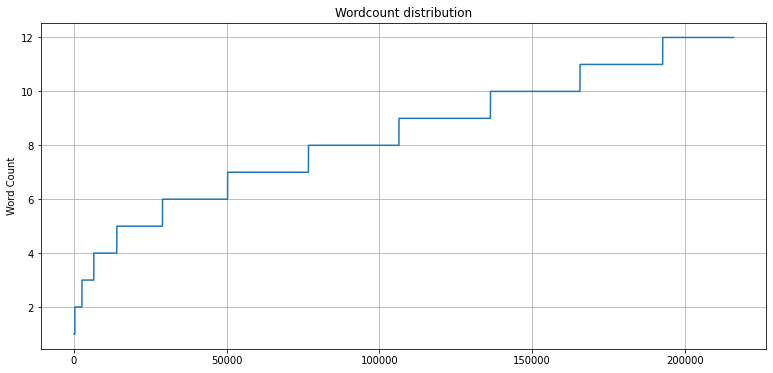

In [ ]:
content=train['incorrect'].astype('str')
content_word_count=[len(content.iloc[i].split()) for i in range(len(content))]
mean_word_count=np.mean(content_word_count)
print(f'Mean Word Count:{mean_word_count}')
index=[i for i in range(0,len(content_word_count))]
fig, ax=plt.subplots(figsize=(13, 6))
plt.plot(index,sorted(content_word_count))
plt.grid()
plt.title("Wordcount distribution")
plt.ylabel("Word Count")
plt.show()

In [ ]:
#text2seq
train_enc_inp = tokenizer_enc.texts_to_sequences(train['incorrect'].astype(str).values)
validation_enc_inp = tokenizer_enc.texts_to_sequences(validation['incorrect'].astype(str).values)
test_enc_inp = tokenizer_enc.texts_to_sequences(test['incorrect'].astype(str).values)

#padding
max_seq_len = 12
train_enc_inp = pad_sequences(train_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
validation_enc_inp = pad_sequences(validation_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')
test_enc_inp = pad_sequences(test_enc_inp, maxlen=max_seq_len, padding='post', truncating='post')

In [ ]:
#text2seq
train_dec_inp = tokenizer_dec.texts_to_sequences(train['dec_correct_inp'].astype(str).values)
validation_dec_inp = tokenizer_dec.texts_to_sequences(validation['dec_correct_inp'].astype(str).values)
test_dec_inp = tokenizer_dec.texts_to_sequences(test['dec_correct_inp'].astype(str).values)

#padding
train_dec_inp = pad_sequences(train_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_inp = pad_sequences(validation_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_inp = pad_sequences(test_dec_inp, maxlen=max_seq_len+1, padding='post', truncating='post')

In [ ]:
#text2seq
train_dec_out = tokenizer_dec.texts_to_sequences(train['dec_correct_out'].astype(str).values)
validation_dec_out = tokenizer_dec.texts_to_sequences(validation['dec_correct_out'].astype(str).values)
test_dec_out = tokenizer_dec.texts_to_sequences(test['dec_correct_out'].astype(str).values)

#padding
train_dec_out = pad_sequences(train_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
validation_dec_out = pad_sequences(validation_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')
test_dec_out = pad_sequences(test_dec_out, maxlen=max_seq_len+1, padding='post', truncating='post')

In [ ]:
with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/train_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_enc_inp, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/val_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_enc_inp, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/test_enc_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_enc_inp, f)

In [ ]:
with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/train_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_inp, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/val_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_inp, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/test_dec_inp_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_inp, f)

In [ ]:
with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/train_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(train_dec_out, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/val_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(validation_dec_out, f)

with open('/content/drive/MyDrive/Self Case studies/CS02 Grammar Error Corrector/data/test_dec_out_20211112.pkl', 'wb') as f:
  pickle.dump(test_dec_out, f)